In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel
from pathlib import Path
import git

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

In [2]:
def generate_gabor_kernel(frequency, wave_number, theta=0.0, aspect_ratio=1.0):
    """Generate a normalized Gabor kernel."""
    n_stds = 3
    sigma_x = wave_number / (2.0 * n_stds * frequency)
    sigma_y = aspect_ratio * sigma_x
    k = np.real(gabor_kernel(frequency=frequency, theta=theta,
                             sigma_x=sigma_x, sigma_y=sigma_y, n_stds=n_stds))
    k -= k.mean()
    nrm = np.linalg.norm(k.ravel())
    if nrm > 1e-12:
        k = k / nrm
    return k

# Load parameters from CSV
param_df = pd.read_csv(ROOT_DIR / "gabor" / "gabor_new.csv")

# Build filters (theta=0 for visualization)
filters = []
for _, row in param_df.iterrows():
    k = generate_gabor_kernel(row['frequency'], row['wave_number'], 
                              theta=0, aspect_ratio=row['aspect_ratio'])
    filters.append({
        'kernel': k,
        'frequency': row['frequency'],
        'wave_number': int(row['wave_number']),
        'aspect_ratio': row['aspect_ratio']
    })

print(f"Built {len(filters)} Gabor filters")

Built 42 Gabor filters


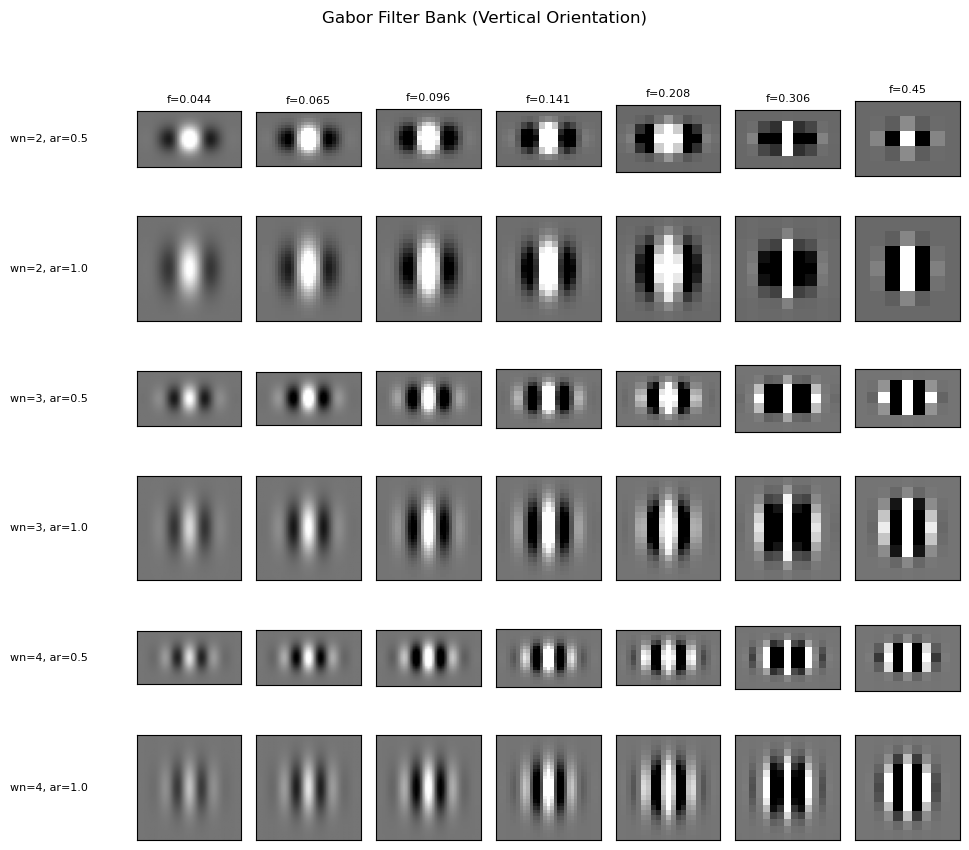

In [5]:
# Organize grid: rows = (wave_number, aspect_ratio), cols = frequency
wave_numbers = sorted(param_df['wave_number'].unique())
aspect_ratios = sorted(param_df['aspect_ratio'].unique())
frequencies = sorted(param_df['frequency'].unique())

row_labels = [(wn, ar) for wn in wave_numbers for ar in aspect_ratios]
nrows, ncols = len(row_labels), len(frequencies)

# Create lookup
fmap = {(f['wave_number'], f['aspect_ratio'], f['frequency']): f['kernel'] for f in filters}

# Consistent colormap limits
all_vals = np.concatenate([f['kernel'].ravel() for f in filters])
vmin, vmax = np.percentile(all_vals, [1, 99])

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.4, nrows * 1.4))

for r, (wn, ar) in enumerate(row_labels):
    for c, freq in enumerate(frequencies):
        ax = axes[r, c]
        kern = fmap.get((wn, ar, freq))
        if kern is not None:
            ax.imshow(kern, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Title on top row only
        if r == 0:
            ax.set_title(f'f={freq}', fontsize=8)
    
    # Row label
    axes[r, 0].set_ylabel(f'wn={wn}, ar={ar}', fontsize=8, rotation=0, 
                          ha='right', va='center', labelpad=35)

plt.suptitle('Gabor Filter Bank (Vertical Orientation)', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(ROOT_DIR / 'gabor' / 'gabor_filter_bank.png', dpi=200, bbox_inches='tight')
plt.show()